In [4]:
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

import geopandas as gpd
from numpy import inf
# from pysal.explore.esda import Moran
from esda.moran import Moran
from pysal.lib import weights
from scipy.spatial.distance import pdist, squareform

In [ ]:
# load data

# Use glob to read all CSV files in the data_path_lasI folder
data_path_lasI_folder = '../Data/Cluster_Results/'
all_files = glob.glob(data_path_lasI_folder + "*.csv")

# Read all CSV files and concatenate them into a single DataFrame
df_las = pd.concat((pd.read_csv(f) for f in all_files), ignore_index=True)
df_las['gene'] = df_las['gene'].replace('rpsL', 'RpsL')

rhl_path = '../../Rhl_all_241101/Cluster_Results/All_clustered.csv'
df_rhl = pd.read_csv(rhl_path, low_memory=False)

/var/folders/z2/q1qv_y2d5wq14w63qr1l_2rh0000gn/T/ipykernel_3249/1104843267.py:8: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  df_las = pd.concat((pd.read_csv(f) for f in all_files), ignore_index=True)


In [7]:
# clean data
df_all = pd.concat([df_las, df_rhl])
df_all = df_all.loc[df_all['Autoinducer'] == 'Without'].copy()
df_all['time'] = df_all['frames'] * 0.25

df_all_24 = df_all.loc[df_all['frames'] == 24]
df_all_24['fluo3'] = df_all_24['fluo2'] / df_all_24['fluo1']

/var/folders/z2/q1qv_y2d5wq14w63qr1l_2rh0000gn/T/ipykernel_3249/1315791349.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_all_24['fluo3'] = df_all_24['fluo2'] / df_all_24['fluo1']


In [13]:
# set plot sytle
sns.set(
    style='ticks', 
    context='talk', 
    palette='colorblind',
    rc={
        "axes.spines.top": False, 
        "axes.spines.right": False,
        "figure.figsize": (6, 6)
    }
)

In [8]:
def Moran_test(df):
    '''
    calculate Moran's I and p-value for each gene in each cluster
    '''
    gene = df['gene'].unique()[0]
    cluster = df['cluster'].unique()[0]
    
    coordinates = df[['x', 'y']].values
    gene_expression = df['fluo3'].values

    # Compute spatial weights
    distance_matrix = squareform(pdist(coordinates))
    threshold = np.percentile(distance_matrix, 10)  # Set a reasonable threshold for neighbors
    spatial_weights = weights.Kernel.from_array(coordinates, bandwidth=threshold)
    
    moran = Moran(gene_expression, spatial_weights)
    # print(f"Gene = {gene}, Cluster = {cluster}, Moran's I = {moran.I}, p-value = {moran.p_sim}")
    
    # Prepare data for Moran's scatter plot
    x = (gene_expression - np.mean(gene_expression)) / np.std(gene_expression)  # Standardized values
    y = spatial_weights.sparse @ x  # Spatial lag
    
    return gene, cluster, x, y, moran.I, moran.p_sim


results = df_all_24.groupby(['gene', 'cluster']).apply(Moran_test).reset_index(drop=True)

/Users/liulaura/opt/anaconda3/envs/image3/lib/python3.10/site-packages/libpysal/weights/distance.py:563: UserWarning: The weights matrix is not fully connected: 
 There are 3 disconnected components.
  W.__init__(self, neighbors, weights, ids, **kwargs)
/Users/liulaura/opt/anaconda3/envs/image3/lib/python3.10/site-packages/libpysal/weights/distance.py:563: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  W.__init__(self, neighbors, weights, ids, **kwargs)
/Users/liulaura/opt/anaconda3/envs/image3/lib/python3.10/site-packages/libpysal/weights/distance.py:563: UserWarning: The weights matrix is not fully connected: 
 There are 4 disconnected components.
  W.__init__(self, neighbors, weights, ids, **kwargs)
/Users/liulaura/opt/anaconda3/envs/image3/lib/python3.10/site-packages/libpysal/weights/distance.py:563: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  W.__init__(self, neighbors, weights,

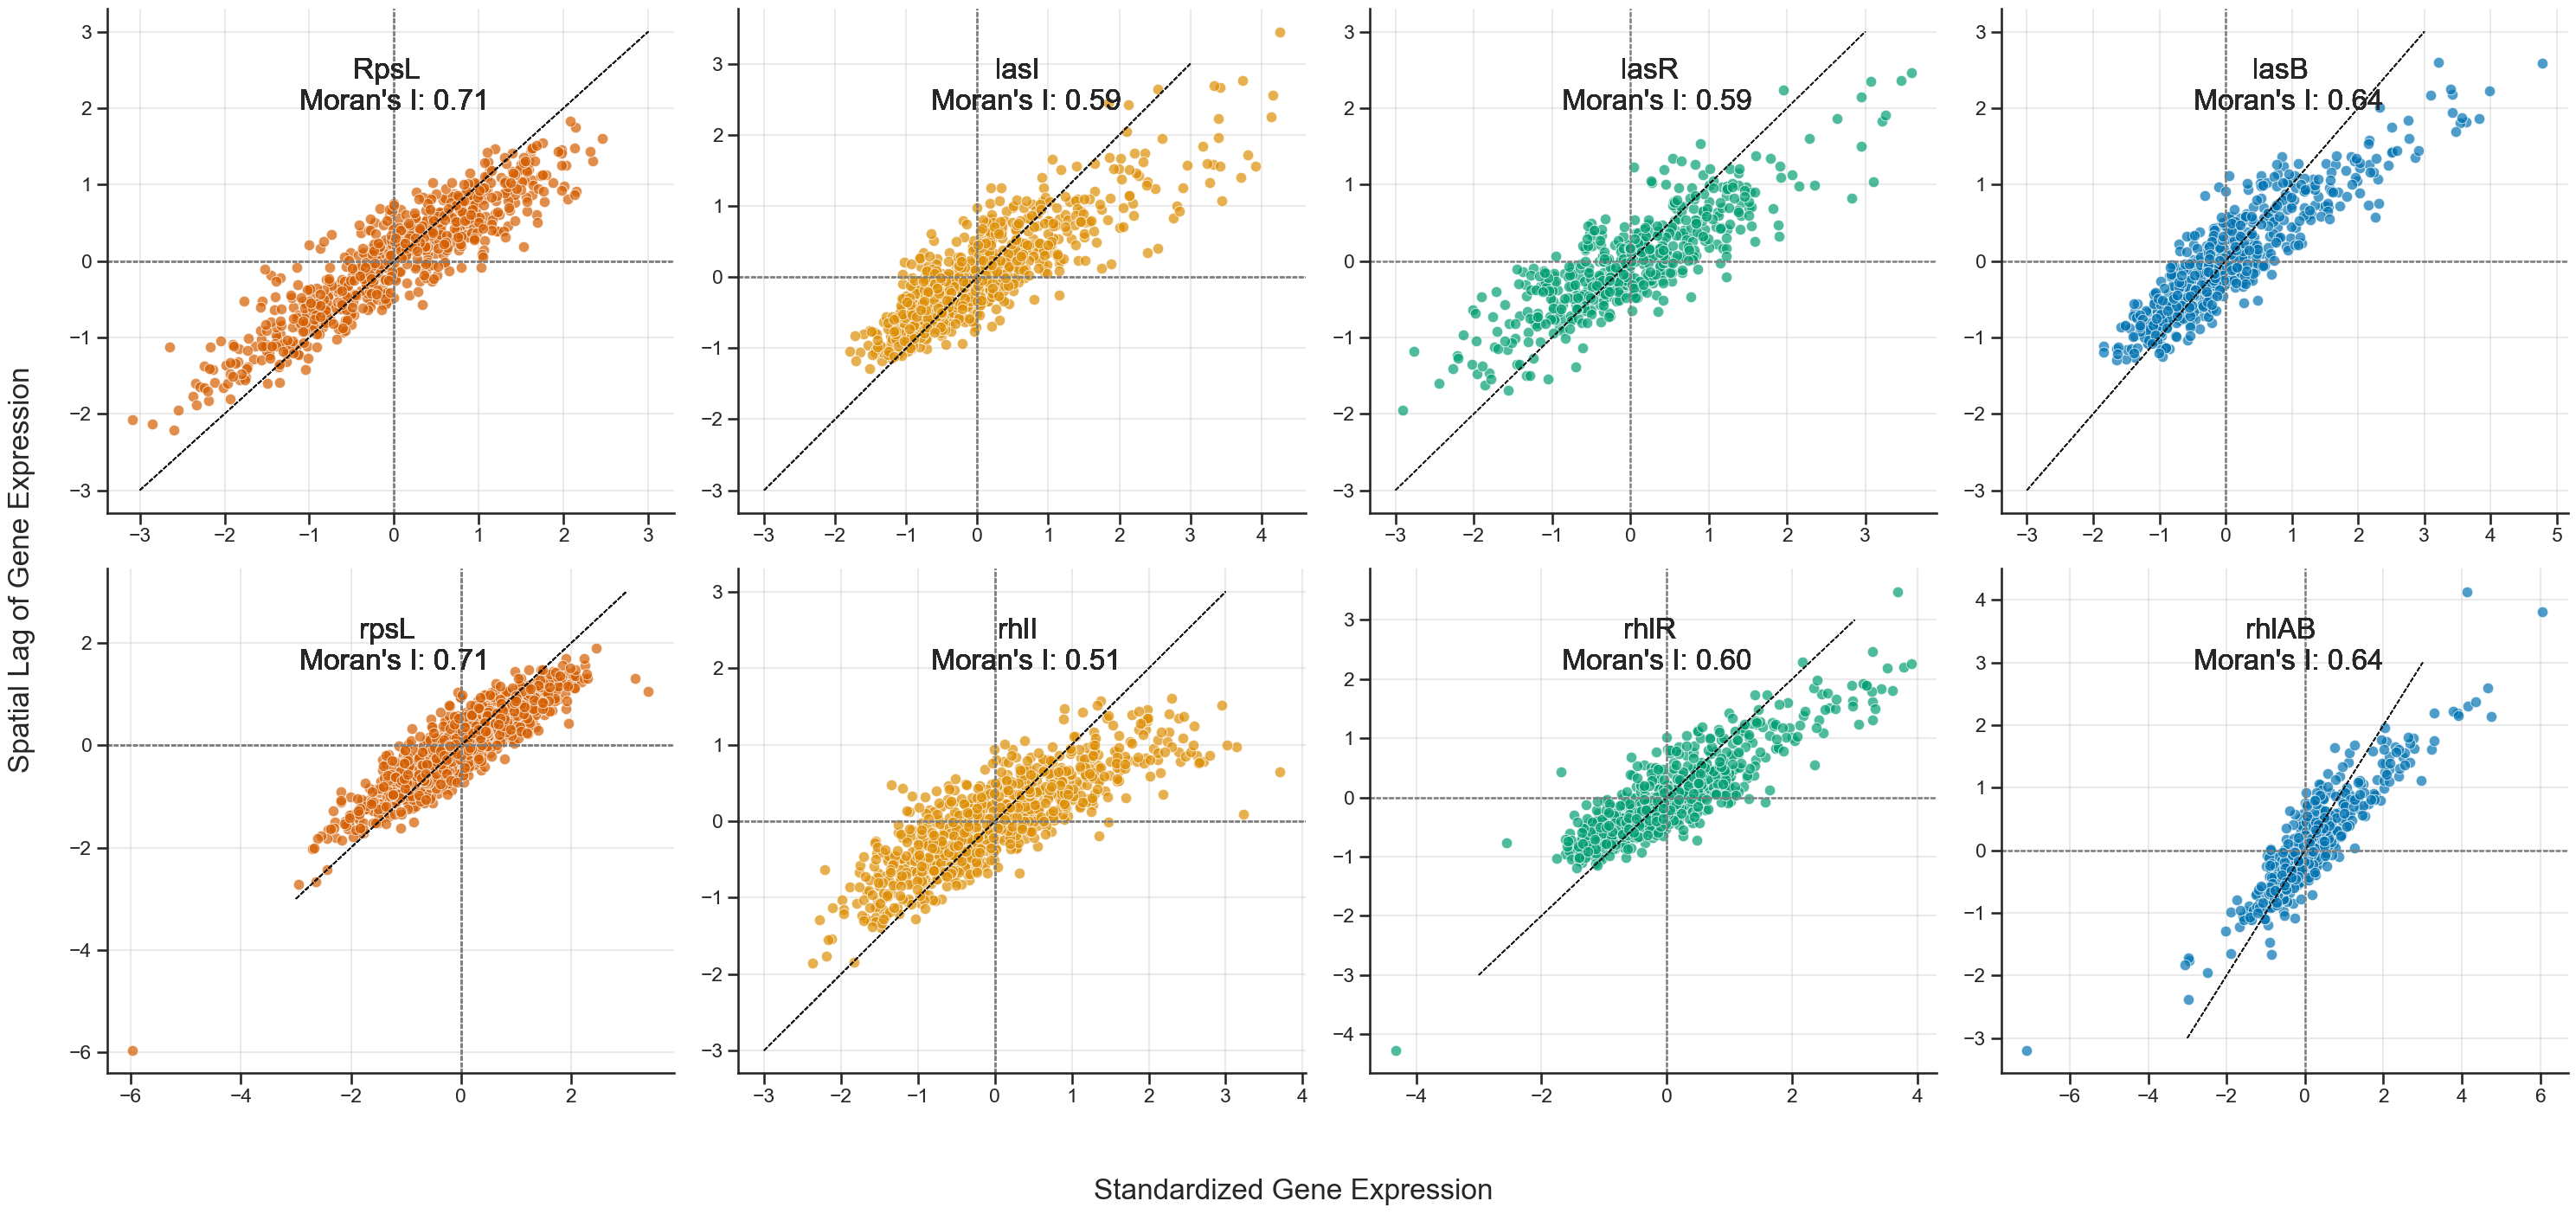

In [16]:
# Prepare to plot
fig, axes = plt.subplots(2, 4, figsize=(30, 15))
axes = axes.flatten()
gene_order = ['RpsL', 'lasI', 'lasR', 'lasB', 'rpsL', 'rhlI', 'rhlR', 'rhlAB']
# results['gene'] = pd.Categorical(results['gene'], categories=gene_order, ordered=True)
unique_genes = df_all_24['gene'].unique()
# Define custom colors for each gene
custom_palette = {'lasB': sns.color_palette("colorblind")[0], 
                  'lasI': sns.color_palette("colorblind")[1], 
                  'lasR': sns.color_palette("colorblind")[2],
                  'RpsL': sns.color_palette("colorblind")[3],
                  'rhlAB': sns.color_palette("colorblind")[0], 
                  'rhlI': sns.color_palette("colorblind")[1], 
                  'rhlR': sns.color_palette("colorblind")[2],
                  'rpsL': sns.color_palette("colorblind")[3]}

gene_to_ax = {gene: ax for gene, ax in zip(gene_order, axes)}

df_moran_result = pd.DataFrame(results.tolist(), columns=['gene', 'cluster', 'x', 'y', 'moran_i', 'p_value'])
moran_I = df_moran_result.groupby('gene')['moran_i'].mean().to_dict()
for res in results:
    gene, cluster, x, y, moran_i, p_value = res
    ax = gene_to_ax[gene]
    sns.scatterplot(x=x, y=y, alpha=0.7, color=custom_palette[gene], ax=ax)
    ax.plot([-3, 3], [-3, 3], 'k--', lw=1)  # 1:1 line
    ax.text(0.5, 0.8, f"{gene} \n Moran's I: {moran_I[gene]:.2f}", fontsize=24, transform=ax.transAxes, ha='center')
    ax.axhline(0, color="gray", linestyle="--", linewidth=1)
    ax.axvline(0, color="gray", linestyle="--", linewidth=1)
    ax.grid(alpha=0.4)

# fig.suptitle("Moran's Scatter Plot", fontsize=24)
fig.supxlabel("Standardized Gene Expression", fontsize=24)
fig.supylabel("Spatial Lag of Gene Expression", fontsize=24, x=0.005)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


In [10]:
results

0     (RpsL, 66.0, [-1.838275171467484, -0.622946574...
1     (RpsL, 67.0, [-1.3438651986293157, 0.112198745...
2     (RpsL, 68.0, [-1.8306367400345744, -0.87821207...
3     (RpsL, 69.0, [-1.271978568436955, -0.962858509...
4     (RpsL, 70.0, [-2.05022853158687, -0.1016264963...
                            ...                        
71    (rpsL, 44.0, [-0.5582326524879531, -0.45286251...
72    (rpsL, 45.0, [0.5564346238478326, -0.661981922...
73    (rpsL, 46.0, [-0.5220192287001019, 1.749994203...
74    (rpsL, 47.0, [-0.698825073938413, -0.645326816...
75    (rpsL, 48.0, [0.4260862290049311, -0.442613965...
Length: 76, dtype: object

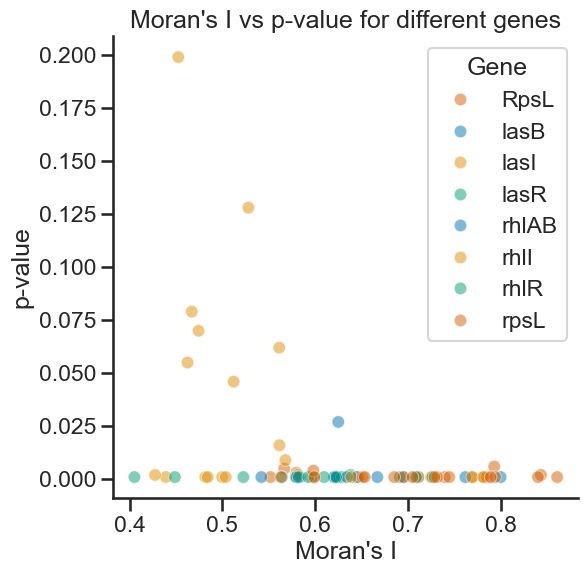

In [18]:
moran_result_las = pd.DataFrame(results.tolist(), columns=['gene', 'cluster', 'x', 'y', 'moran_i', 'p_value'])
sns.scatterplot(data=moran_result_las, x='moran_i', y='p_value', hue='gene', palette=custom_palette, alpha=0.5)
plt.xlabel("Moran's I")
plt.ylabel("p-value")
plt.title("Moran's I vs p-value for different genes")
plt.legend(title='Gene')
plt.show()

### We can observe from this plot that yellow dots which represent for signal genes (rhlI and lasI) have lower moran's I and higher P-value. This means they are significantly less clustered

In [19]:
print(moran_result_las.groupby(['gene']).moran_i.mean())

gene
RpsL     0.706632
lasB     0.635921
lasI     0.594665
lasR     0.586848
rhlAB    0.641345
rhlI     0.506471
rhlR     0.602959
rpsL     0.709415
Name: moran_i, dtype: float64
